In [1]:
import os
import numpy as np
import librosa
import soundfile as sf
import tensorflow as tf
from tensorflow.keras import layers
from scipy.interpolate import interp1d

# === Audio Processing Functions ===

def audio_to_log_magnitude(file_path, sr=22050, n_fft=1024, hop_length=512):
    y, _ = librosa.load(file_path, sr=sr)
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    mag = np.log1p(np.abs(S))
    return mag.astype(np.float32), sr

def normalize_spectrogram(mag):
    mean, std = np.mean(mag), np.std(mag)
    return (mag - mean) / (std + 1e-8), mean, std

def denormalize_spectrogram(norm_mag, mean, std):
    return norm_mag * std + mean

def split_into_windows(mag, window_size=512, step_size=256):
    num_frames = mag.shape[1]
    pad_len = (-(num_frames - window_size) % step_size) % step_size
    mag_padded = np.pad(mag, ((0, 0), (0, pad_len)), mode='constant')
    num_windows = (mag_padded.shape[1] - window_size) // step_size + 1

    windows = np.stack([
        mag_padded[:, i * step_size:i * step_size + window_size]
        for i in range(num_windows)
    ])
    return windows[..., np.newaxis]  # shape: (num_windows, freq_bins, window_size, 1)

def reconstruct_from_windows(windows, window_size=512, step_size=256):
    freq_bins, total_frames = windows.shape[1], (windows.shape[0] - 1) * step_size + window_size
    output, weight = np.zeros((freq_bins, total_frames)), np.zeros((freq_bins, total_frames))
    for i, win in enumerate(windows):
        start = i * step_size
        output[:, start:start + window_size] += win[..., 0]
        weight[:, start:start + window_size] += 1.0
    return output / (weight + 1e-8)

def spectrogram_to_audio(mag, n_fft=1024, hop_length=512, iterations=60):
    mag = np.expm1(mag)
    phase = np.exp(2j * np.pi * np.random.rand(*mag.shape))
    S = mag * phase
    for _ in range(iterations):
        y = librosa.istft(S, hop_length=hop_length)
        S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
        phase = np.exp(1j * np.angle(S))
        S = mag * phase
    return librosa.istft(S, hop_length=hop_length)

def match_window_count(source, target_len):
    current_len = len(source)
    x_old = np.linspace(0, 1, current_len)
    x_new = np.linspace(0, 1, target_len)
    return [source[int(np.clip(i * current_len, 0, current_len - 1))] for i in x_new]

# === Autoencoder ===

def build_conv_autoencoder(input_shape, latent_dim=128):
    freq_bins, time_frames, channels = input_shape

    # Calculamos la forma más cercana compatible con maxpooling x2
    target_freq = ((freq_bins + 3) // 4) * 4  # múltiplo de 4 más cercano ≥ 513
    freq_padding = target_freq - freq_bins
    pad_top = freq_padding // 2
    pad_bottom = freq_padding - pad_top

    encoder_input = tf.keras.Input(shape=input_shape)

    # Pad entrada para que sea divisible entre 4
    x = layers.ZeroPadding2D(padding=((pad_top, pad_bottom), (0, 0)))(encoder_input)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    shape_before_flatten = x.shape[1:]  # (freq, time, channels)
    x = layers.Flatten()(x)
    x = layers.Dense(latent_dim, activation='relu')(x)
    encoder = tf.keras.Model(encoder_input, x, name='encoder')

    # Decoder
    decoder_input = tf.keras.Input(shape=(latent_dim,))
    x = layers.Dense(np.prod(shape_before_flatten), activation='relu')(decoder_input)
    x = layers.Reshape(shape_before_flatten)(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(channels, (3, 3), activation='linear', padding='same')(x)

    # Recorta el padding original
    x = layers.Cropping2D(cropping=((pad_top, pad_bottom), (0, 0)))(x)

    decoder = tf.keras.Model(decoder_input, x, name='decoder')

    # Autoencoder
    auto_input = tf.keras.Input(shape=input_shape)
    encoded = encoder(auto_input)
    decoded = decoder(encoded)
    autoencoder = tf.keras.Model(auto_input, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder, decoder


# === Style Transfer ===

def stylize_audio_blocks(encoder, decoder, content_mag, style_mag=None, alpha=0.5,
                         window_size=512, step_size=256):
    content_windows = split_into_windows(content_mag, window_size, step_size)
    style_windows = split_into_windows(style_mag, window_size, step_size) if style_mag is not None else None

    if style_windows is not None:
        style_windows = match_window_count(style_windows, len(content_windows))

    stylized_windows = []
    for i, content_block in enumerate(content_windows):
        content_emb = encoder.predict(content_block[np.newaxis, ...])
        if style_windows is not None:
            style_emb = encoder.predict(style_windows[i][np.newaxis, ...])
            mixed_emb = (1 - alpha) * content_emb + alpha * style_emb
        else:
            mixed_emb = content_emb
        stylized_block = decoder.predict(mixed_emb)[0]
        stylized_windows.append(stylized_block)

    stylized_mag = reconstruct_from_windows(np.array(stylized_windows), window_size, step_size)
    return stylized_mag

# === Dataset ===

def audio_to_spectrogram(file_path, sr=22050, n_fft=1024, hop_length=256):
    y, _ = librosa.load(file_path, sr=sr)
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    mag = np.log1p(np.abs(S))
    return mag.astype(np.float32)

def load_dataset(folder, shape=(513, 256)):
    X = []
    for fname in os.listdir(folder):
        if fname.endswith('.wav'):
            mag = audio_to_spectrogram(os.path.join(folder, fname))
            if mag.shape[1] >= shape[1]:
                mag = mag[:, :shape[1]]
                X.append(mag)
    return np.array(X)[..., np.newaxis]

# === Main Pipeline ===

def style_transfer_pipeline(content_path, style_path, output_path,
                            encoder, decoder, window_size=256, step_size=128,
                            alpha=0.5, sr=22050):
    content_mag, _ = audio_to_log_magnitude(content_path, sr=sr)
    style_mag, _ = audio_to_log_magnitude(style_path, sr=sr)

    stylized_mag = stylize_audio_blocks(encoder, decoder, content_mag, style_mag,
                                        alpha=alpha, window_size=window_size,
                                        step_size=step_size)
    audio_out = spectrogram_to_audio(stylized_mag)
    sf.write(output_path, audio_out, sr)




In [2]:
# === Training Example ===
folder = './'  # carpeta con .wav
X_train = load_dataset(folder)
input_shape = X_train.shape[1:]
autoencoder, encoder, decoder = build_conv_autoencoder(input_shape)
autoencoder.fit(X_train, X_train, epochs=50, batch_size=8)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.1118
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1104
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1073
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0940
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0646
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.1043
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0473
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0643
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0722
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0704
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0615
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0486
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0396
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0424
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0394
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━

In [ ]:
style_transfer_pipeline(
    content_path='short_bohemian-2.wav',
    style_path='short_huapango-2.wav',
    output_path='output_stylized_bohemia_huapango_2.wav',
    encoder=encoder,
    decoder=decoder,
    window_size=256,
    step_size=128,
    alpha=0.75
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from librosa.display import specshow

In [ ]:
def plot_spec(audio):
  D = librosa.amplitude_to_db(librosa.stft(audio), ref=np.max)
  specshow(D, y_axis='log')

<ipython-input-30-dfbb6d2a7dd2>:2: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(audio), ref=np.max)


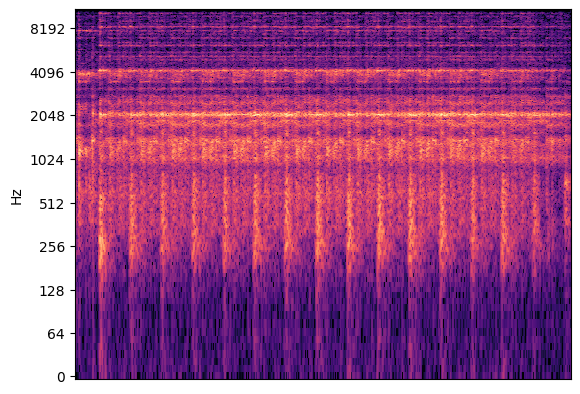

In [ ]:
sr = 5550
content = './output_stylized_bohemia_huapango_2.wav'
audio, _ = librosa.core.load(content, sr=sr)
aa = plot_spec(audio)

In [ ]:
from IPython.display import Audio

In [ ]:
Audio(audio, rate=sr)

## Another version

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import librosa
import soundfile as sf

# ==== CONFIGURACIÓN ====
SR = 22050
N_FFT = 1024
HOP_LENGTH = 256
WINDOW_SIZE = 256
STEP_SIZE = 128
LATENT_DIM = 128
EPOCHS = 50
alpha = 0.9
BATCH_SIZE = 8

# ==== UTILIDADES DE AUDIO ====
def audio_to_log_magnitude(file_path, sr=SR):
    y, _ = librosa.load(file_path, sr=sr)
    S = librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH)
    mag = np.log1p(np.abs(S))
    return mag.astype(np.float32)

def spectrogram_to_audio(mag, iterations=60):
    # Pad mag to match the expected shape of phase
    pad_width = ((0, 1), (0, 0))  # Pad the first dimension (frequency bins) by 1 row
    mag = np.pad(mag, pad_width=pad_width, mode='constant', constant_values=0)

    mag = np.expm1(mag)
    phase = np.exp(2j * np.pi * np.random.rand(*mag.shape))
    S = mag * phase
    for _ in range(iterations):
        y = librosa.istft(S, hop_length=HOP_LENGTH)
        S = librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH)
        phase = np.exp(1j * np.angle(S))
        S = mag * phase
    y = librosa.istft(S, hop_length=HOP_LENGTH)
    return y

def split_into_windows(mag, window_size=WINDOW_SIZE, step_size=STEP_SIZE):
    windows = []
    for start in range(0, mag.shape[1] - window_size + 1, step_size):
        window = mag[:, start:start + window_size]
        windows.append(window)
    return np.array(windows)[..., np.newaxis]  # (num_windows, freq_bins, frames, 1)

def reconstruct_from_windows(windows, window_size=WINDOW_SIZE, step_size=STEP_SIZE):
    freq_bins = windows.shape[1]
    total_frames = (windows.shape[0] - 1) * step_size + window_size
    output = np.zeros((freq_bins, total_frames))
    weight = np.zeros((freq_bins, total_frames))
    for i, win in enumerate(windows):
        start = i * step_size
        output[:, start:start + window_size] += win[..., 0]
        weight[:, start:start + window_size] += 1.0
    return output / (weight + 1e-8)

# ==== DATASET ====
def audio_to_fixed_spectrogram(file_path):
    mag = audio_to_log_magnitude(file_path)
    mag = mag[:512]  # recorte a 512 filas
    return split_into_windows(mag)

def load_dataset(folder):
    X = []
    for fname in os.listdir(folder):
        if fname.endswith('.wav'):
            blocks = audio_to_fixed_spectrogram(os.path.join(folder, fname))
            X.extend(blocks)
    return np.array(X)

# ==== VAE ====
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_vae(input_shape, latent_dim=LATENT_DIM):
    # Encoder
    encoder_inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_inputs)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Flatten()(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = models.Model(encoder_inputs, [z, z_mean, z_log_var], name='encoder')

    # Decoder
    decoder_inputs = tf.keras.Input(shape=(latent_dim,))
    x = layers.Dense((input_shape[0] // 4) * (input_shape[1] // 4) * 64, activation='relu')(decoder_inputs)
    x = layers.Reshape((input_shape[0] // 4, input_shape[1] // 4, 64))(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')(x)
    decoder_outputs = layers.Conv2D(1, 3, activation='linear', padding='same')(x)
    decoder = models.Model(decoder_inputs, decoder_outputs, name='decoder')

    # VAE
    class VAE(tf.keras.Model):
        def __init__(self, encoder, decoder):
            super().__init__()
            self.encoder = encoder
            self.decoder = decoder
            self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")

        def train_step(self, data):
            with tf.GradientTape() as tape:
                z, z_mean, z_log_var = self.encoder(data)
                reconstruction = self.decoder(z)
                reconstruction_loss = tf.reduce_mean(tf.square(data - reconstruction)) * np.prod(input_shape)
                kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
                kl_loss = tf.reduce_mean(kl_loss)
                total_loss = reconstruction_loss + kl_loss
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            return {"loss": self.total_loss_tracker.result()}

    vae = VAE(encoder, decoder)
    vae.compile(optimizer='adam')
    return vae, encoder, decoder

# ==== TRANSFERENCIA DE ESTILO ====
def stylize(content_mag, style_mag, encoder, decoder, alpha=0.5):
    content_windows = split_into_windows(content_mag[:512])
    style_windows = split_into_windows(style_mag[:512])
    stylized = []
    for i, c_win in enumerate(content_windows):
        s_win = style_windows[i % len(style_windows)]
        c_emb, _, _ = encoder.predict(c_win[np.newaxis, ...])
        s_emb, _, _ = encoder.predict(s_win[np.newaxis, ...])
        z_mix = (1 - alpha) * c_emb + alpha * s_emb
        out = decoder.predict(z_mix)[0]
        stylized.append(out)
    return reconstruct_from_windows(np.array(stylized))




## Change in build_vae function

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import librosa
import soundfile as sf

# ==== CONFIGURACIÓN ====
SR = 22050
N_FFT = 1024
HOP_LENGTH = 256
WINDOW_SIZE = 256
STEP_SIZE = 128
LATENT_DIM = 256 #128
EPOCHS = 50
alpha = 0.9
BATCH_SIZE = 8

# ==== UTILIDADES DE AUDIO ====
def audio_to_log_magnitude(file_path, sr=SR):
    y, _ = librosa.load(file_path, sr=sr)
    S = librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH)
    mag = np.log1p(np.abs(S))
    return mag.astype(np.float32)

def spectrogram_to_audio(mag, iterations=60):
    # Pad mag to match the expected shape of phase
    pad_width = ((0, 1), (0, 0))  # Pad the first dimension (frequency bins) by 1 row
    mag = np.pad(mag, pad_width=pad_width, mode='constant', constant_values=0)

    mag = np.expm1(mag)
    phase = np.exp(2j * np.pi * np.random.rand(*mag.shape))
    S = mag * phase
    for _ in range(iterations):
        y = librosa.istft(S, hop_length=HOP_LENGTH)
        S = librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH)
        phase = np.exp(1j * np.angle(S))
        S = mag * phase
    y = librosa.istft(S, hop_length=HOP_LENGTH)
    return y

def split_into_windows(mag, window_size=WINDOW_SIZE, step_size=STEP_SIZE):
    windows = []
    for start in range(0, mag.shape[1] - window_size + 1, step_size):
        window = mag[:, start:start + window_size]
        windows.append(window)
    return np.array(windows)[..., np.newaxis]  # (num_windows, freq_bins, frames, 1)

def reconstruct_from_windows(windows, window_size=WINDOW_SIZE, step_size=STEP_SIZE):
    freq_bins = windows.shape[1]
    total_frames = (windows.shape[0] - 1) * step_size + window_size
    output = np.zeros((freq_bins, total_frames))
    weight = np.zeros((freq_bins, total_frames))
    for i, win in enumerate(windows):
        start = i * step_size
        output[:, start:start + window_size] += win[..., 0]
        weight[:, start:start + window_size] += 1.0
    return output / (weight + 1e-8)

# ==== DATASET ====
def audio_to_fixed_spectrogram(file_path):
    mag = audio_to_log_magnitude(file_path)
    mag = mag[:512]  # recorte a 512 filas
    return split_into_windows(mag)

def load_dataset(folder):
    X = []
    for fname in os.listdir(folder):
        if fname.endswith('.wav'):
            blocks = audio_to_fixed_spectrogram(os.path.join(folder, fname))
            X.extend(blocks)
    return np.array(X)

# ==== VAE ====
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        #z_mean, z_log_var, z_mixture_weights = inputs  # Agrega pesos de mezcla
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_vae(input_shape, latent_dim=LATENT_DIM):
    # Encoder
    encoder_inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_inputs)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x) # Added another Conv layer
    x = layers.MaxPooling2D(2, padding='same')(x) # Added another MaxPooling layer
    x = layers.Flatten()(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = models.Model(encoder_inputs, [z, z_mean, z_log_var], name='encoder')

    # Decoder
    decoder_inputs = tf.keras.Input(shape=(latent_dim,))
    x = layers.Dense((input_shape[0] // 8) * (input_shape[1] // 8) * 128, activation='relu')(decoder_inputs) # Adjusted for new layers
    x = layers.Reshape((input_shape[0] // 8, input_shape[1] // 8, 128))(x) # Adjusted for new layers
    x = layers.Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same')(x) # Added corresponding Conv2DTranspose
    x = layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')(x) # Added corresponding Conv2DTranspose
    decoder_outputs = layers.Conv2D(1, 3, activation='linear', padding='same')(x)
    decoder = models.Model(decoder_inputs, decoder_outputs, name='decoder')

    # ... (rest of the VAE code remains the same)
    # VAE
    class VAE(tf.keras.Model):
        def __init__(self, encoder, decoder):
            super().__init__()
            self.encoder = encoder
            self.decoder = decoder
            self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")

        def train_step(self, data):
            with tf.GradientTape() as tape:
                z, z_mean, z_log_var = self.encoder(data)
                reconstruction = self.decoder(z)
                reconstruction_loss = tf.reduce_mean(tf.square(data - reconstruction)) * np.prod(input_shape)
                kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
                kl_loss = tf.reduce_mean(kl_loss)
                total_loss = reconstruction_loss + kl_loss
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            return {"loss": self.total_loss_tracker.result()}

    vae = VAE(encoder, decoder)
    vae.compile(optimizer='adam')
    return vae, encoder, decoder

# ==== TRANSFERENCIA DE ESTILO ====
def stylize(content_mag, style_mag, encoder, decoder, alpha=0.5):
    content_windows = split_into_windows(content_mag[:512])
    style_windows = split_into_windows(style_mag[:512])
    stylized = []
    for i, c_win in enumerate(content_windows):
        s_win = style_windows[i % len(style_windows)]
        c_emb, _, _ = encoder.predict(c_win[np.newaxis, ...])
        s_emb, _, _ = encoder.predict(s_win[np.newaxis, ...])
        z_mix = (1 - alpha) * c_emb + alpha * s_emb
        out = decoder.predict(z_mix)[0]
        stylized.append(out)
    return reconstruct_from_windows(np.array(stylized))

### Other version with Gaussian

In [ ]:
# ==== MAIN ====
if __name__ == '__main__':
    dataset = load_dataset('./')  # carpeta con .wav
    input_shape = dataset.shape[1:]
    vae, encoder, decoder = build_vae(input_shape)
    vae.fit(dataset, epochs=EPOCHS, batch_size=BATCH_SIZE)

    content_mag = audio_to_log_magnitude('short_bohemian-2.wav')[:512]
    style_mag = audio_to_log_magnitude('short_huapango-2.wav')[:512]
    stylized_mag = stylize(content_mag, style_mag, encoder, decoder, alpha=0.2)

    y_out = spectrogram_to_audio(stylized_mag)
    sf.write('output_stylized_bohemia_huapango-5.wav', y_out, SR)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 19368.8730
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 10084.1611
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 10771.6465
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 9413.8105
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 8215.5322
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 8480.5723
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 7879.4956
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 7780.7002
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 7717.3452
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 7720.5684
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 7491.2124
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 7374.9946
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 6971.3306
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 6851.5566
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 11

In [ ]:
from librosa.display import specshow

In [ ]:
def plot_spec(audio):
  D = librosa.amplitude_to_db(librosa.stft(audio), ref=np.max)
  specshow(D, y_axis='log')

<ipython-input-8-dfbb6d2a7dd2>:2: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(audio), ref=np.max)


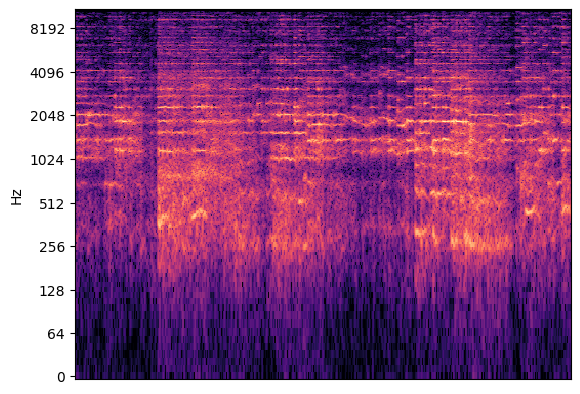

In [ ]:
sr = 5550
content = './output_stylized_bohemia_huapango-5.wav'
audio, _ = librosa.core.load(content, sr=sr)
aa = plot_spec(audio)

<ipython-input-24-dfbb6d2a7dd2>:2: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(audio), ref=np.max)


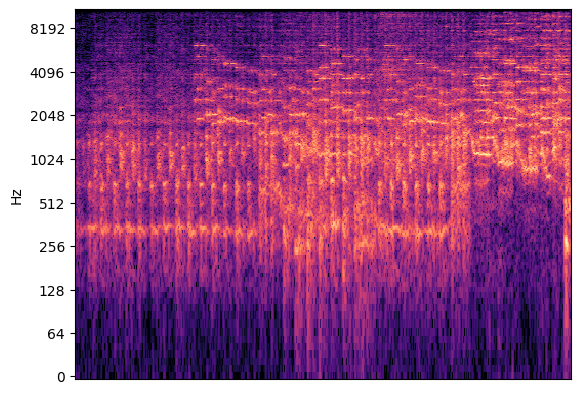

In [ ]:
import matplotlib.pyplot as plt

sr = 5550
# content = './output_stylized_bohemia_nut.wav'
# audio, _ = librosa.core.load(content, sr=sr)

def mel_spec(y):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    return librosa.power_to_db(S)


plt.figure(figsize=(14, 5))
mel_audio = mel_spec(audio)
librosa.display.specshow(mel_audio, sr=sr, x_axis='time', y_axis='mel')

In [ ]:
from IPython.display import Audio

In [ ]:
Audio(audio, rate=sr)